In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

plt.style.use('seaborn-v0_8-whitegrid')
import scipy.stats as ss
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

from arch import arch_model
from scipy.optimize import minimize 
from scipy.stats import t
from scipy.stats.distributions import t


In [45]:
def qqplot(x, dist="norm"):
    fig, ax = plt.subplots(1,1)
    t, o = ss.probplot(x, dist=dist, plot=ax)
    
    if isinstance(dist, str):
        title = f"{dist.title()} Q-Q Plot"
    else:
        title = f"{dist.dist.name.title()} Q-Q Plot"
        
    
    min_ = min(t[0])
    max_ = max(t[0])
    
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.set_title(title)

    ax.scatter(t[0],t[1])
    ax.plot((min_, min_), (max_,max_))

def plot_acf_graphs(x: pd.Series, title: str):
    fig, axs = plt.subplots(2,1)
    ax1, ax2 = axs

    ax1.set_title(title)
    ax1.set_ylabel(title)
    ax1.plot(x, c='b')

    ax2.set_ylabel('ACF')
    ax2.set_xlabel('Lag')

    sm.graphics.tsa.plot_acf(x, ax=ax2, lags=50, title=None, auto_ylims=True, c='orange')


    
def get_linspace(data, num_stdevs=5, points=1001):
    """
    Return linspace of the data by calculating (mu-num_stdevs*std, mu+num_stdevs*std)
    """
    mean = np.mean(data)
    stdev = np.std(data)

    linspace = np.linspace(mean - num_stdevs*stdev, mean + num_stdevs*stdev, points)

    return linspace

def es_n(loss: np.ndarray, var: float):
    """
    Calculate expected shortfall.
    Takes array of length n, and calculates avg(loss) given loss[0:n]>var

    :param loss: array of n observations, previous loss 
    :param var: Value at Risk
    """
    # check if loss[0 to n inclusive] > var
    breach_mask = loss>var
    if not breach_mask.sum():
        # return = for no breaches
        return 0
    return loss[breach_mask].sum() / breach_mask.sum()



In [8]:
def get_q2_data():
    df =pd.read_csv('../data/QRM-2022-cw2-data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['TSLA'].pct_change())
    df['loss'] = -100*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    df = df.iloc[1:,:]
    return df.set_index('Date')

df = get_q2_data()

In [32]:
train_mask = df.index < pd.to_datetime('26-11-2021', format='%d-%m-%Y')
train_df = df[train_mask]
test_df = df[~train_mask]

# 1i)

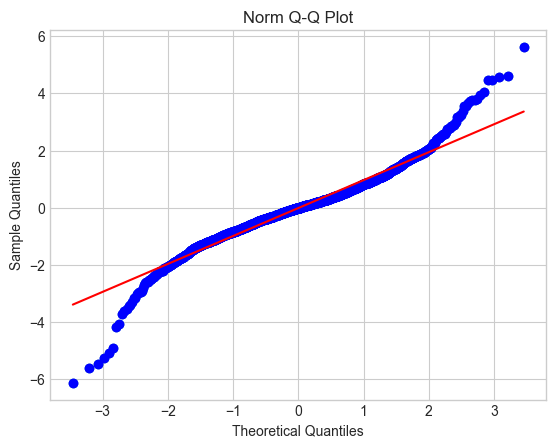

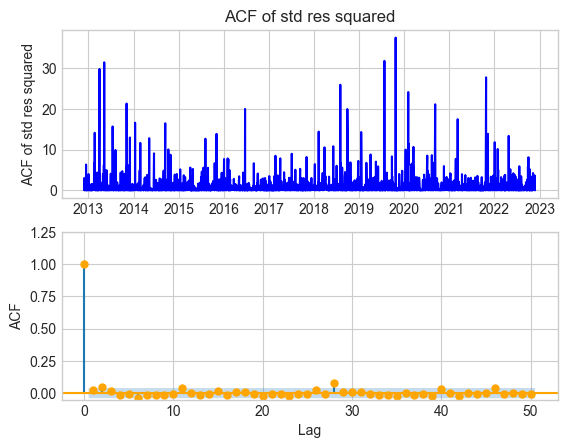

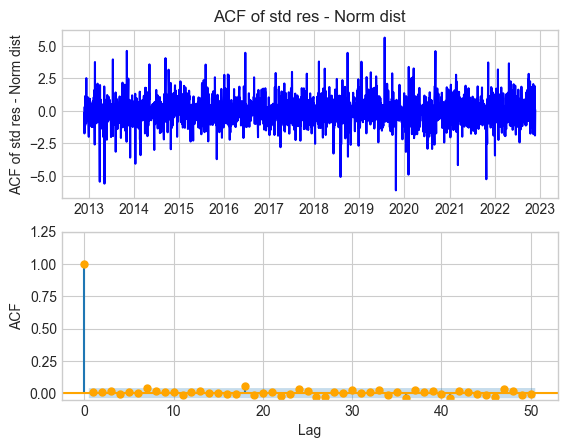

In [10]:

model = arch_model(train_df['loss'],
                    mean='constant', 
                    vol='GARCH', 
                    p=1, q=1, rescale=True, dist='normal')
model_fit_norm = model.fit(update_freq=-1, disp=0)
qqplot(model_fit_norm.std_resid, dist='norm'); plt.show()
plot_acf_graphs(model_fit_norm.std_resid**2, 'ACF of std res squared'); plt.show()
plot_acf_graphs(model_fit_norm.std_resid, 'ACF of std res - Norm dist'); plt.show()


# 1ii)

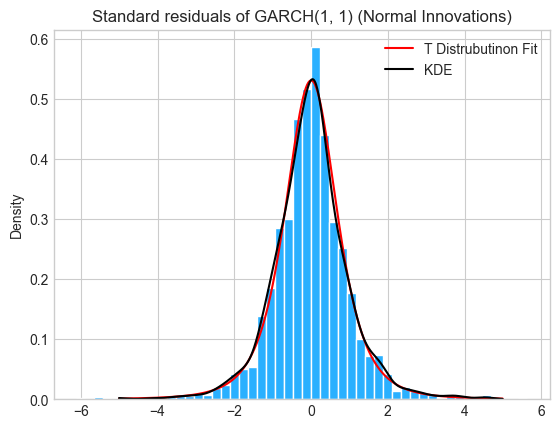

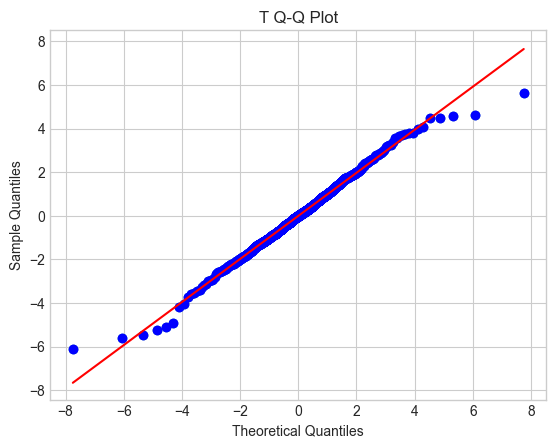

In [34]:
# fit t dist to residules 
dof, loc, scale = t.fit(model_fit_norm.std_resid, floc=0)

t_dist_fit=t(df=dof, loc=loc, scale=scale)


x = get_linspace(model_fit_norm.std_resid)
kde = ss.gaussian_kde(model_fit_norm.std_resid)
t_dist_fit_pdf = t_dist_fit.pdf(x)


plt.plot(x, t_dist_fit_pdf, label= 'T Distrubutinon Fit', color='red');
plt.plot(x, kde(x), label='KDE', color='k');
plt.hist(model_fit_norm.std_resid, bins=50, density=True,facecolor='#2ab0ff', edgecolor='white');
plt.ylabel('Density')
plt.title("Standard residuals of GARCH(1, 1) (Normal Innovations)"); plt.legend(); plt.show()

qqplot(model_fit_norm.std_resid, dist=t_dist_fit); plt.show()


### Experimental after here

In [49]:
alpha = 0.99

for date in test_df.index:
    # add most recent data point
    model_fit_norm.model.y = df[:date]['loss']

    # forecast 1 ahead
    forecasts = model_fit_norm.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]

    # get quantile from std res
    q = np.quantile(model_fit_norm.std_resid.values, alpha)
    std = np.sqrt(var)
    value_at_risk = q*std + model_fit_norm.params.mu

    # get ES from std res and
    res_exp_sh = es_n(model_fit_norm.std_resid, q)

    exp_sh = (var**0.5)*res_exp_sh

    ## store the es and var in the DF shift by one